In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
inspector.get_columns("measurement")

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation')

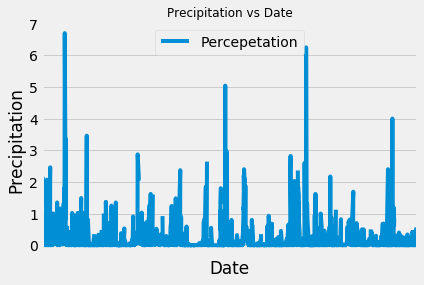

In [18]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Design a query to retrieve the last 12 months of precipitation data and plot the results
lst_year= session.query(Measurement.date).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()
    

   
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
date =  dt.datetime.strptime('2017-08-23', "%Y-%m-%d") -  dt.timedelta(days=3*365)
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement).\
filter(Measurement.date > '2016-08-23').\
order_by(Measurement.date).all()
meas_date = []
meas_perc = []
for meas in data:
    meas_date.append(meas.date)
    meas_perc.append(meas.prcp)
    
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame({"Date": meas_date, "Percepetation": meas_perc})
# Sort the dataframe by date
df = df.sort_values(by="Date")
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.title("Precipitation vs Date", fontsize=12)
plt.xlabel("Date")
plt.xticks([])
plt.ylabel("Precipitation")


![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(df["Percepetation"].describe())

,Percepetation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [52]:
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
act_stat = station_count[0][0]
# List the stations and the counts in descending order.
print(act_stat)
print(station_count)

USC00519281
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == act_stat).all()

# highest temperature recorded, and average temperature of the most active station?


[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

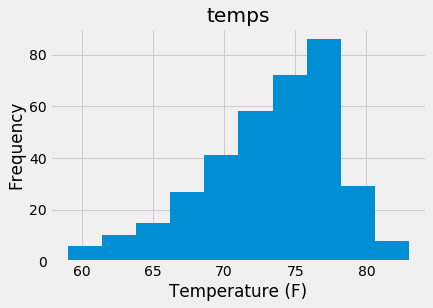

In [36]:
# Choose the station with the highest number of temperature observations.
temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == act_stat).\
    filter(Measurement.date >= '2016-08-23').all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df = pd.DataFrame(temps, columns=["date", "temps"])
df.hist()
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps())

[(62.0, 69.57142857142857, 74.0)]


In [41]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
data_temp = calc_temps('2012-02-28', '2012-03-05')
data_temp

[(62.0, 69.57142857142857, 74.0)]

Text(0, 0.5, 'Temperature')

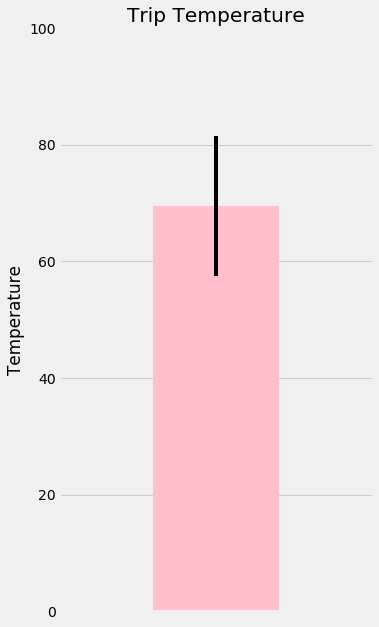

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = data_temp[0][2] - data_temp[0][0]
plt.figure(figsize=(5,10)) 
plt.bar(0, data_temp[0][1], yerr=yerr, color="pink")
plt.ylim(0,100)
plt.xlim(-1,1)
plt.xticks([])
plt.title("Trip Temperature")
plt.ylabel("Temperature")


In [51]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, \
              func.sum(Measurement.prcp)).filter(Measurement.station==Station.station).\
              group_by(Measurement.station).order_by((func.sum(Measurement.prcp)).desc()).\
              filter(Measurement.date >= "2017-06-10").\
              filter(Measurement.date <= "2017-06-21").all()
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  6.569999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.2500000000000004),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.21),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  2.1799999999999997),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.6200000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


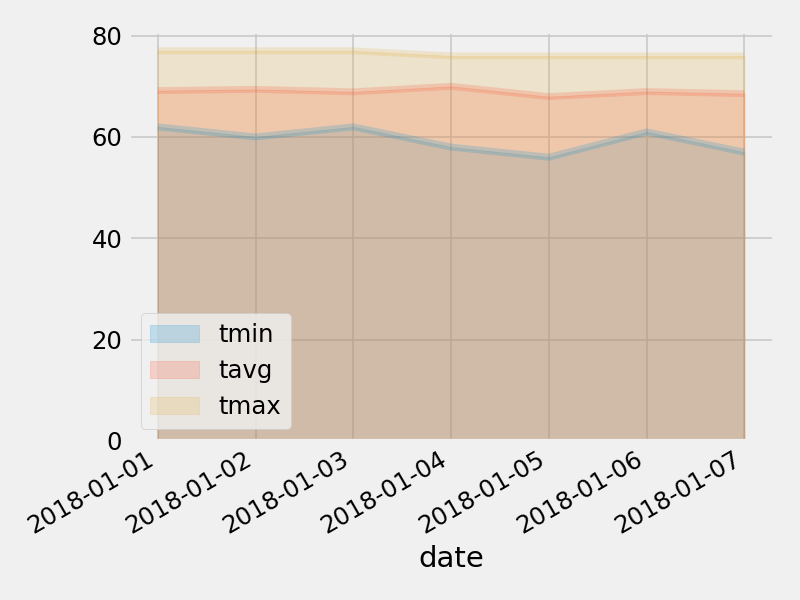

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
